# Assignment 3, Question 2

<b>Group 58</b>
* <b> Student 1 </b> : Luc Reinink, 1068948
* <b> Student 2 </b> : Gerrit Merz, 1553410

**Reading material**
* [1] *Oriol Vinyals, Alexander Toshev, Samy Bengio, Dumitru Erhan, "Show and Tell: A Neural Image Caption Generator"*, CVPR, 2015. https://arxiv.org/abs/1411.4555

**Task:**
Implement and test the image caption generator proposed in [1], see further instructions below. 
Please insert your code between two consecutive occurrences of # ...

<b><font color='red'>NOTE</font></b> When submitting your notebook, please make sure that the training history of your model is visible in the output. This means that you should **NOT** clean your output cells of the notebook. Make sure that your notebook runs without errors in linear order.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import pickle
import time
import nltk

import keras.backend as K
#from tensorflow.keras import Model
#from tensorflow.keras.models import load_model 
#from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Dropout, concatenate
from tensorflow.keras import losses, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import drive

# training parameters
embedding_dim = 512
lstm_dim = 500
lstm_dropout = 0.5
batch_size = 100

Using TensorFlow backend.


In [0]:
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout


# Mount Google Drive
We will save the data and our model there, in the folder deeplearning2020_ass3_task1.
**This requires about 600 MB**.


In [3]:
if not os.path.isdir('drive'):
  drive.mount('drive')
else:
  print('drive already mounted')

base_path = os.path.join('drive', 'My Drive', 'deeplearning2020_ass3_task1')
if not os.path.isdir(base_path):
  os.makedirs(base_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


# Download Data - Flickr8k

<b><font color='red'>Please don't distribute the dataset</font></b> 

This is a preprocessed version of the Flickr8k dataset, with punctuation and special tokens removed. Furthermore, any word which occurs less than 5 times in the whole corpus has been removed. The images have been rescaled to 128x128 RGB.

**images:** numpy array (8091,128,128,3), uint8, holding 8091 RGB images.

**captions:** collection of 5 human-annotated captions for each image. Stored as a python list of length 8091. 
*   *captions[i]* is a list of length 5, for i=0..8090, holding the 5 annotations for the i'th image.
*   *captions[i][j]* is a caption, represented as a list of strings, for i=0..8090, j=0..4. 
*   For example: *captions[42][3] = ['a', 'young', 'boy', 'wearing', 'a', 'red', 'coat', 'is', 'playing', 'in', 'a', 'long', 'tunnel']*.
*   Thus, there are in total 8091 * 5 = 40455 captions.

<b><font color='red'>Please don't distribute the dataset</font></b> 

In [4]:
if not os.path.isdir('drive'):
  raise AssertionError('Google drive seems to be unmounted -- please run cell above.')
  
flickr_file = os.path.join(base_path, 'Flickr8k_processed.pkl')

if not os.path.isfile(flickr_file):
  start_time = time.time()
  if not os.path.isfile(flickr_file):
    ! wget https://surfdrive.surf.nl/files/index.php/s/kOIDM5tQPzv6IID/download -O Flickr8k_processed.pkl
    shutil.move('Flickr8k_processed.pkl', flickr_file)
  print("Elapsed time: {} seconds.".format(time.time()-start_time))
else:
  print('Found file {}'.format(flickr_file))

images, captions = pickle.load(open(flickr_file, 'rb'))

print('Data loaded.')
print('images: {} {} {}'.format(images.shape, type(images), images.dtype))
print('captions: {} {}'.format(len(captions), type(captions)))

Found file drive/My Drive/deeplearning2020_ass3_task1/Flickr8k_processed.pkl
Data loaded.
images: (8091, 128, 128, 3) <class 'numpy.ndarray'> uint8
captions: 8091 <class 'list'>


# Extract Image Representation

* Use the 'Conv_1' layer from *MobileNetV2* to generate neural codes for each image in the array *images*. 
* Please generate a (8091,20480) numpy array in single precision (dtype=np.float32) holding the neural codes, where each row holds the code for the corresponding row in *images*. 
* Call the resulting array *image_codes*.
* **Hint:** Process the images in batches (of e.g. 200), as the GPU won't be able to process all 8091 images in parallel.
* **Hint:** **MobileNetV2 requires images in floating point as inputs**, with pixels rescaled to range [-1,1]. In order to save some RAM (and reduce troubles with Colab running out of resources), convert only the batches into single precision, and keep the *images* in their original format (uint8).

In [0]:
def get_layer_functor(model, layer_name):
  inp = model.input 
  output =  model.get_layer(layer_name).output
  return K.function([inp], [output])

def eval_layer(x, layer_functor):
  return layer_functor(x)[0]

def eval_layer_batched(model, layer_name, x, batch_size):
  layer_functor = get_layer_functor(model, layer_name)
  idx = 0
  ret_vals = None
  while idx < x.shape[0]:
    if idx + batch_size > x.shape[0]:
      batch_x = x[idx:, ...]
    else:
      batch_x = x[idx:(idx+batch_size), ...]

    batch_vals = eval_layer(batch_x, layer_functor)
    if ret_vals is None:
      ret_vals = batch_vals
    else:
      ret_vals = np.concatenate((ret_vals, batch_vals), 0)

    idx += batch_size
  return ret_vals

In [6]:
def get_image_codes(images):      
  convnet = MobileNetV2(input_shape=(128,128,3), 
                          include_top=False, 
                          weights='imagenet')

  image_codes = eval_layer_batched(convnet, 'Conv_1', images, 200)
  image_codes = np.array(image_codes.reshape(8091,20480), dtype=np.float32)
  
  return image_codes

image_codes = get_image_codes(images)
print(image_codes.shape)

9412608/9406464 [==============================] - 0s 0us/step
(8091, 20480)


# Analyze Captions

* Find the maximal caption length in the *captions* and store it in a variable *max_caption_length*.
* Construct a collection of all words (i.e. strings) occurring in the captions, and count their occurrences. 
***Include the special word '_' ***(the *stop word*, signaling the end of the captions) in this collection.
* Construct a dictionary *word_to_idx* which maps words to integers as follows:
    *   '_' ->  0
    *   most frequent word -> 1
    *   second most frequent word -> 2
    *   ...

* Construct a dictionary *idx_to_word* which inverts the mapping *word_to_idx*.
* Store the number of unique words, including '_', in a variable *num_words*.

In [0]:
caps = []
for cap in captions:
  for c in cap:
    caps.append(c)

max_length,longest_element = max([(len(x),x) for x in caps])

words = []
for cap in caps:
  for word in cap:
    words.append(word)

counts = dict()
for word in words:
    if word in counts:
        counts[word] += 1
    else:
        counts[word] = 1
  
counts = sorted(counts.items(), reverse = True, key=lambda item: item[1])

word_to_idx = dict()
idx = 1
word_to_idx['_'] = 0
for i in counts:
  word_to_idx[i[0]] = idx
  idx = idx + 1

max_caption_length = max_length
word_dict = counts
word_to_idx = word_to_idx
idx_to_word = dict((v, k) for k, v in word_to_idx.items())
num_words = len(word_to_idx)

# Train/Validation/Test Split

In [0]:
val_images = images[0:1000, ...]
val_codes = image_codes[0:1000, ...]
val_captions = [captions[k] for k in range(1000)]

test_images = images[1000:2000, ...]
test_codes = image_codes[1000:2000, ...]
test_captions = [captions[k] for k in range(1000, 2000)]

train_images = images[2000:, ...]
train_codes = image_codes[2000:, ...]
train_captions = [captions[k] for k in range(2000, images.shape[0])]

# Convert Train and Validation Data into Matrix Format

This encodes the captions to integer matrices using the mapping *word_to_idx*. 
It also duplicates the corresponding image codes.
The result is two matrices {train, val}_codes and {train, val}_y, which hold image codes and integer encoded captions, whose rows correspond to each other.

In [9]:
def convert_data(codes, captions, max_caption_length, word_to_idx):
  if codes.shape[0] != len(captions):
    raise AssertionError("Different number of codes and captions.")
  
  N = codes.shape[0]
  duplicate_codes = None
  labels = None
  for k in range(5):
    cur_labels = np.zeros((N, max_caption_length), dtype=np.uint32)
    for l in range(N):
      for count, w in enumerate(captions[l][k]):
        cur_labels[l, count] = word_to_idx[w]

    if duplicate_codes is None:
      duplicate_codes = codes
      labels = cur_labels
    else:
      duplicate_codes = np.concatenate((duplicate_codes, codes), 0)
      labels = np.concatenate((labels, cur_labels), 0)
  
  return duplicate_codes, labels

train_codes, train_y = convert_data(train_codes, train_captions, max_caption_length, word_to_idx)
val_codes, val_y = convert_data(val_codes, val_captions, max_caption_length, word_to_idx)

print(train_codes.shape)
print(train_y.shape)
print(val_codes.shape)
print(val_y.shape)

(30455, 20480)
(30455, 35)
(5000, 20480)
(5000, 35)


# Show Random Images from Train and Validation Sets


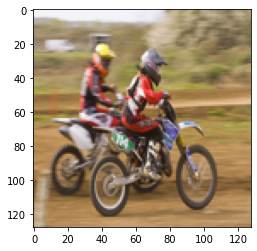

['two', 'bmx', 'riders', 'racing', 'on', 'a', 'track', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']





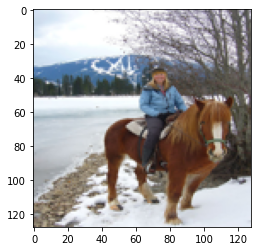

['a', 'woman', 'dressed', 'in', 'a', 'blue', 'jacket', 'and', 'blue', 'jeans', 'rides', 'a', 'brown', 'horse', 'near', 'a', 'frozen', 'lake', 'and', 'snow-covered', 'mountain', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']





In [10]:
def show_random_image_and_captions(images, labels, idx_to_word):
  n = images.shape[0]
  idx = np.random.randint(0, n)

  plt.imshow(images[idx % images.shape[0], ...])
  plt.show()

  encoded_caption = labels[idx, ...]
  encoded_caption = [k for k in encoded_caption if k >= 0]
  caption = [idx_to_word[i] for i in encoded_caption]
  print(caption)
  print('\n\n')

show_random_image_and_captions(train_images, train_y, idx_to_word)
show_random_image_and_captions(val_images, val_y, idx_to_word)

# Make Model

The model takes two inputs:

*   *image_input*: placeholder for image codes.
*   *caption_inputs*: placeholder for integer-encoded captions. 

You need to insert the following structure:

*   Image embedding: *Dense* layer, mapping image codes to embeddings of length *embedding_dim*.
*   Caption embedding: *Embedding* layer, mapping integers to embeddings of length *embedding_dim*.
*   Concatenate Image embedding and Caption embeddings along the time axis. The image embedding should be at time t=0.
*   LSTM with *lstm_dim* units, taking the concatenated embedding as input.
*   Apply Dropout with rate 0.5 to the LSTM.
*   Output layer: *Dense* layer, mapping the output of the LSTM to a categorical distribution (via *softmax*) of length *num_words*.

**Hint:** The function K.expand_dims() might be useful here.



In [0]:
# training parameters
embedding_dim = 512
lstm_dim = 500
lstm_dropout = 0.5
batch_size = 100

In [0]:
from keras.layers.merge import add
from keras.layers import Reshape, concatenate

def make_model(code_length, max_caption_length, embedding_dim, num_words, lstm_dim, lstm_dropout):

  # inputs
  image_input = Input(shape=(code_length,))
  caption_input = Input(shape=(max_caption_length - 1,))

  # Dense Layer: Mapping image codes to embeddings of length embedding_dim
  img_emb = Dense(embedding_dim, activation ='relu')(image_input)
  img_emb = Reshape((1, embedding_dim))(img_emb)

  # Embedding Layer: Mapping integers to embeddings of length embedding_dim
  capt_emb = Embedding(max_caption_length-1, embedding_dim)(caption_input)
  lstm = LSTM(lstm_dim, return_sequences=True, dropout=lstm_dropout)(concatenate([img_emb, capt_emb], axis=1))

  output = Dense(num_words, activation='softmax')(lstm)

  return Model([image_input, caption_input], output)

model = make_model(code_length=train_codes.shape[1], 
                   max_caption_length=max_caption_length, 
                   embedding_dim=embedding_dim, 
                   num_words=num_words, 
                   lstm_dim=lstm_dim, 
                   lstm_dropout=lstm_dropout)

In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 20480)        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          10486272    input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, 512)       0           dense_1[0][0]                    
____________________________________________________________________________________________

In [0]:
#Adam optimizer
opt = optimizers.Adam(learning_rate= 0.001, amsgrad=True)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy'])

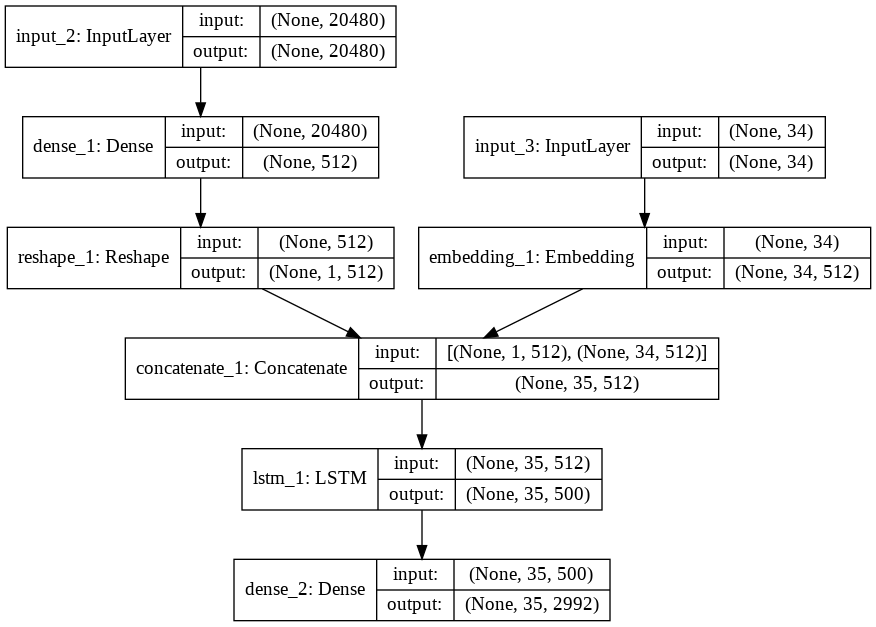

In [15]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

__How does the input and output need to be organized?__
The input of the model is a neural code of the image and a sequence of words that form the caption. The paper states: "The LSTM model is trained to predict each word of the sentence after it has seen the image as well as all preceding words as defined by $p(S_t|I, S_0, . . . , S_{t−1})$." Hence, the input of the model should include one less word than the max length of any caption.

__For how many time steps T should the LSTM be unrolled?__
The LSTM should be unrolled for the maximum caption length since the LSTM processes one word in each time step. In our case, that is 35.

__For each time step, $t = 0, . . . , T − 1$, which embedding should be input to the LSTM and what should be the target?__
The quote from the paper (above) is also applicable to answer this question. The model uses all previously seen words of the current image to predict the new word, so to generate target $x$, input $x-1$ should be the input.


# Train Model

* Use Adam with learning rate 0.001 and early stopping with patience 1. 
Provide the separate validation set for early stopping.
* Use a batch size of 100.
* Use a maximal number of epochs of 100 (early stopping will likely stop training much earlier).
* Use crossentropy as loss function.
* Report which data serves as input and which serves as output, and why.
* **Hint:** Use the sparse version of crossentropy, in order to avoid memory issues.

In [0]:
class DataIterator():

    def __init__(self, X, y, batch_size=32):
        self.X = X
        self.y = y

        self.num_data = len(X)
        self.batch_size = batch_size
        self.reset()

    def __iter__(self):
        return self

    def reset(self):
        self.idx = 0
        self.order = np.random.permutation(self.num_data)

    def __next__(self):
        X_ids = []
        while len(X_ids) < self.batch_size:
            X_id = self.order[self.idx] # copy random id from initial shuffling
            X_ids.append(X_id)
            self.idx += 1 # 
            if self.idx >= self.num_data: # exception if all examples of data have been seen (iterated)
                self.reset()
                raise StopIteration()
        
        batch_X = self.X[np.array(X_ids)]
        batch_y = self.y[np.array(X_ids)]

        return batch_X, batch_y

    def all(self):
        return self.X, self.y

In [0]:
batch_train_iter = DataIterator(train_codes, train_y, batch_size)
batch_val_iter = DataIterator(val_codes, val_y, batch_size)

def train_gen():
    while True:
        train_batches = [[[X, y[:,:-1]], [np.expand_dims(y, axis=-1)]] for X, y in batch_train_iter]
        for train_batch in train_batches:
            yield train_batch
            
def val_gen():
    while True:
        train_batches = [[[X, y[:,:-1]], [np.expand_dims(y, axis=-1)]] for X, y in batch_val_iter]
        for train_batch in train_batches:
            yield train_batch

In [18]:
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        min_delta=0,
                                        patience=1,
                                        verbose=1, 
                                        mode='auto')

# ...

train_steps_epoch = 50
val_steps_epoch = int(len(val_codes) / batch_size)
epochs = 100

model.fit_generator(train_gen(), validation_data=val_gen(), 
                    steps_per_epoch=train_steps_epoch,
                    validation_steps=val_steps_epoch, epochs=epochs, 
                    callbacks=[early_stopping_callback])

# ...

model.save(os.path.join(base_path, 'model.h5'))

Epoch 1/100
50/50 [==============================] - 8s 150ms/step - loss: 2.4654 - sparse_categorical_accuracy: 0.7061 - val_loss: 1.6860 - val_sparse_categorical_accuracy: 0.7282
Epoch 2/100
50/50 [==============================] - 5s 101ms/step - loss: 1.6524 - sparse_categorical_accuracy: 0.7306 - val_loss: 1.6235 - val_sparse_categorical_accuracy: 0.7383
Epoch 3/100
50/50 [==============================] - 5s 102ms/step - loss: 1.5740 - sparse_categorical_accuracy: 0.7392 - val_loss: 1.5688 - val_sparse_categorical_accuracy: 0.7455
Epoch 4/100
50/50 [==============================] - 5s 103ms/step - loss: 1.4837 - sparse_categorical_accuracy: 0.7478 - val_loss: 1.4879 - val_sparse_categorical_accuracy: 0.7495
Epoch 5/100
50/50 [==============================] - 5s 104ms/step - loss: 1.4370 - sparse_categorical_accuracy: 0.7501 - val_loss: 1.3850 - val_sparse_categorical_accuracy: 0.7507
Epoch 6/100
50/50 [==============================] - 7s 141ms/step - loss: 1.4017 - sparse_cate

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


__Which data serves as input and which serves as output, and why?__
The neural codes of images and the words that form the caption (minus the last value, as discussed above) serve as the input. The words that form the caption _with_ the last value serve as output. As discussed above, the image code with all previous words are used to get the current word. Hence, the last word is not necessary to train with.

# Evaluate Model

* Evaluate and report the final train and validation loss.

In [19]:
train_steps_epoch = int(len(train_codes) / batch_size)
val_steps_epoch = int(len(val_codes) / batch_size)

training_loss, training_acc = model.evaluate_generator(train_gen(), 
                                                       train_steps_epoch)
validation_loss, validation_accuracy = model.evaluate_generator(val_gen(), 
                                                                val_steps_epoch)

print("Training loss:", training_loss * 100)
print("Validation loss:", validation_loss * 100)
# ...

Training loss: 139.23509120941162
Validation loss: 135.03849506378174


# Make Decoder

* Make a greedy decoder model, which iteratively predicts the most likely word at each time step. The decoder is akin to the trained model above, but with a crucial difference: at time step t (t > 0), the LSTM takes the embedding of the word *predicted at time step t-1* as input. At time t=0, the LSTM takes the image embedding as input.
* The decoder should return the predicted captions, encoded as integer matrix of shape (batch_size, max_caption_length).
* Equip the decoder with the weights of the trained model. 
* **Hint:** You will need to pass on the internal state of the LSTM from time step to time step. To this end, use the argument *return_state=True* when creating the LSTM, and the *initial_state* argument when calling the LSTM. 
* **Hint:** Use the argument *weights* to pass the parameters of the trained model. This should contain the weights for image embedding, word embedding, LSTM, and output layer. Use the methods *get_weights()* and *set_weights()* to this end.
* **Hint:** The functions *K.expand_dims()*, *K.argmax()*, and *K.stack()* might be useful here.

In [20]:
for layer in model.layers:
    print(layer.name)

input_2
dense_1
input_3
reshape_1
embedding_1
concatenate_1
lstm_1
dense_2


In [21]:
from keras.layers import Lambda

def make_decoder(code_length, max_caption_length, embedding_dim, num_words, lstm_dim, lstm_dropout, weights):
  
  # input
  image_input = Input(shape=(code_length,))
  
  # ...
  model = Dense(embedding_dim, activation ='relu', name="img_embedding")(image_input)
  model = Reshape((1, embedding_dim))(model)
  model = LSTM(lstm_dim, dropout=lstm_dropout, name="lstm")(model)
  model = Dense(num_words, activation='softmax', name="output")(model)
  model = Lambda(lambda x: K.argmax(x, axis=-1))(model)
  model = Embedding(max_caption_length-1, embedding_dim, name="word_embedding")(model)
  # ...

  model.get_layer("img_embedding").set_weights(weights[0])
  model.get_layer("lstm").set_weights(weights[1])
  model.get_layer("output").set_weights(weights[2])
  model.get_layer("word_embedding").set_weights(weights[3])

  return model

# Get the weights from trained model, and put them in a list 'weights'.
# ...
img_embedding_weights = None
lstm_weights = None
word_embedding_weights = None
output_weights = None

for layer in model.layers:
    if layer.name == "embedding_1":
        word_embedding_weights = layer.get_weights()
    if layer.name == "dense_1":
        img_embedding_weights = layer.get_weights()
    if layer.name == "lstm_1":
        lstm_weights = layer.get_weights()
    if layer.name == "dense_2":
        output_weights = layer.get_weights()

weights = [img_embedding_weights, lstm_weights, 
           output_weights, word_embedding_weights]
# ...

decoder = make_decoder(code_length=train_codes.shape[1], 
                       max_caption_length=max_caption_length,
                       embedding_dim=embedding_dim,
                       num_words=num_words, 
                       lstm_dim=lstm_dim, 
                       lstm_dropout=lstm_dropout,
                       weights=weights)

opt = optimizers.Adam(learning_rate= 0.001, amsgrad=True)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy'])

AttributeError: ignored

# Predict Test Captions

*   Use the decoder to predict the test captions.
*   Decode them to text using the mapping *idx_to_word*.
*   Show 10 random test images and their predicted captions. Categorize them like in Figure 5 in the paper.
*   Report the 1-gram, 2-gram, 3-gram, and 4-gram BLEU scores of the test predictions. **Hint:** You can use the *nltk* package for this. 


In [0]:
# ...

# ...

## Peer review
__Gerrit:__ We split up the tasks, Luc was assigned to Task 1 and I worked on Task 2. However, Luc helped me out with Task 2 as I was struggling to get solid results. He ended up doing also half of Task 2, so I think he deserves a better grade than me.

__Luc:__ I did task 1 and Gerrit was supposed to do task 2. He did not manage to get the model working. At that point, I took over and continued. I did not have enough time to fully finish the assignment on my own. I contributed more to this and spent more time trying to finish the assignment, so I think I deserve a better grade.